In [143]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [144]:
df = pd.read_csv("vix_2011_2019.csv")

In [145]:
print(df.head())

         Date       Open       High    Low      Close  Adj Close  Volume
0  2011-02-11  16.530001  16.530001  15.55  15.690000  15.690000       0
1  2011-02-14  16.070000  16.260000  15.22  15.950000  15.950000       0
2  2011-02-15  16.299999  16.750000  16.27  16.370001  16.370001       0
3  2011-02-16  16.309999  16.740000  15.84  16.719999  16.719999       0
4  2011-02-17  17.010000  17.299999  15.88  16.590000  16.590000       0


In [146]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2011 non-null   object 
 1   Adj Close  2011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 31.5+ KB


In [148]:
df['Date'] = pd.to_datetime(df['Date'])

In [149]:
df = df.set_index(['Date'], drop=True)

In [150]:
df.head(10)

,Adj Close
Date,
2011-02-11,15.690000
2011-02-14,15.950000
2011-02-15,16.370001
2011-02-16,16.719999
2011-02-17,16.590000
2011-02-18,16.430000
2011-02-22,20.799999
2011-02-23,22.129999
2011-02-24,21.320000


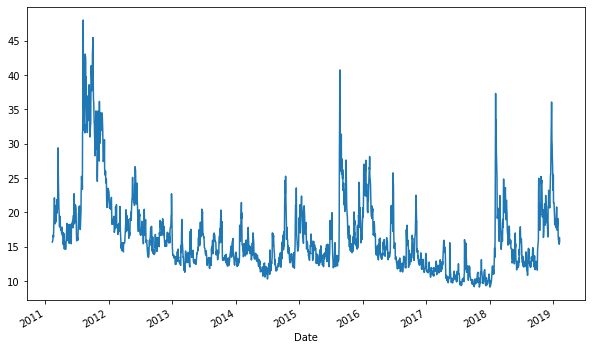

In [151]:
# df = df.sort_index()
plt.figure(figsize=(10, 6))
df['Adj Close'].plot();

In [152]:
split_date = pd.Timestamp('2018-01-01')

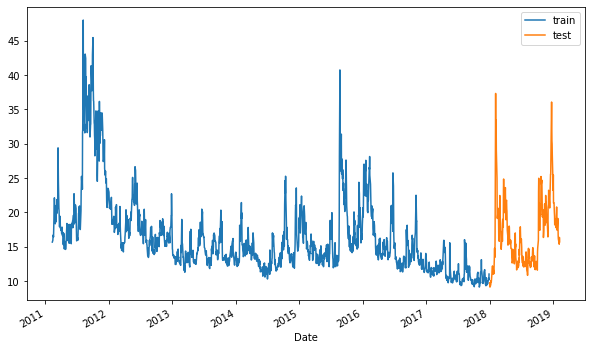

In [153]:
df =  df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [154]:
pd.DataFrame(train)

,Adj Close
Date,
2011-02-11,15.690000
2011-02-14,15.950000
2011-02-15,16.370001
2011-02-16,16.719999
2011-02-17,16.590000
...,...
2017-12-22,9.900000
2017-12-26,10.250000
2017-12-27,10.470000


In [155]:
# scale train and test data to [-1, 1]

scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(pd.DataFrame(train))
test_sc = scaler.transform(pd.DataFrame(test))

In [156]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [157]:
X_train

array([[-0.66289243],
       [-0.64951107],
       [-0.62789496],
       ...,
       [-0.94287185],
       [-0.93154915],
       [-0.94647452]])

In [158]:
y_train

array([[-0.64951107],
       [-0.62789496],
       [-0.60988168],
       ...,
       [-0.93154915],
       [-0.94647452],
       [-0.90221307]])

## NN

In [159]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1732/1732 [==============================] - 1s 508us/step - loss: 0.0305
Epoch 2/100
1732/1732 [==============================] - 1s 477us/step - loss: 0.0065
Epoch 3/100
1732/1732 [==============================] - 1s 497us/step - loss: 0.0061
Epoch 4/100
1732/1732 [==============================] - 1s 483us/step - loss: 0.0062
Epoch 5/100
1732/1732 [==============================] - 1s 486us/step - loss: 0.0061
Epoch 00005: early stopping


In [160]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.883
The R2 score on the Test set is:	0.761


## LSTM

In [161]:
 X_train

array([[-0.66289243],
       [-0.64951107],
       [-0.62789496],
       ...,
       [-0.94287185],
       [-0.93154915],
       [-0.94647452]])

In [162]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.values#.as_matrix()
y_train = y_train.values#.as_matrix()

X_test = X_test.values#.as_matrix()
y_test = y_test.values#.as_matrix()

In [163]:
X_train

array([[-0.66289243],
       [-0.64951107],
       [-0.62789496],
       ...,
       [-0.94287185],
       [-0.93154915],
       [-0.94647452]])

In [164]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (1732, 1, 1)
Test shape:  (277, 1, 1)


In [165]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1732/1732 [==============================] - 1s 724us/step - loss: 0.0417
Epoch 2/100
1732/1732 [==============================] - 1s 719us/step - loss: 0.0083
Epoch 3/100
1732/1732 [==============================] - 1s 744us/step - loss: 0.0060
Epoch 4/100
1732/1732 [==============================] - 1s 694us/step - loss: 0.0060
Epoch 5/100
1732/1732 [==============================] - 1s 723us/step - loss: 0.0060
Epoch 6/100
1732/1732 [==============================] - 1s 696us/step - loss: 0.0060
Epoch 00006: early stopping


In [166]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.895
The R2 score on the Test set is:	0.776


In [167]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

277/277 [==============================] - 0s 501us/step - loss: 0.0143
NN: 0.015285
LSTM: 0.014324


In [168]:
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

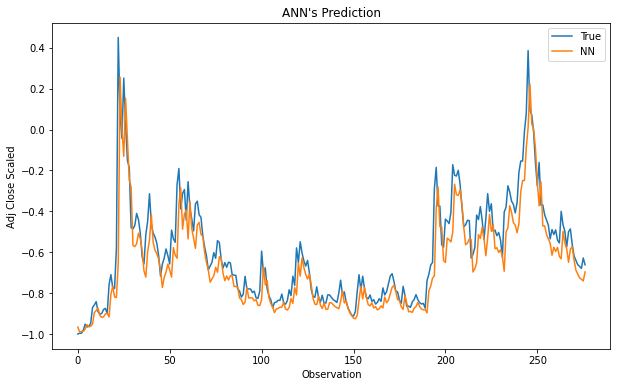

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_nn, label='NN')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

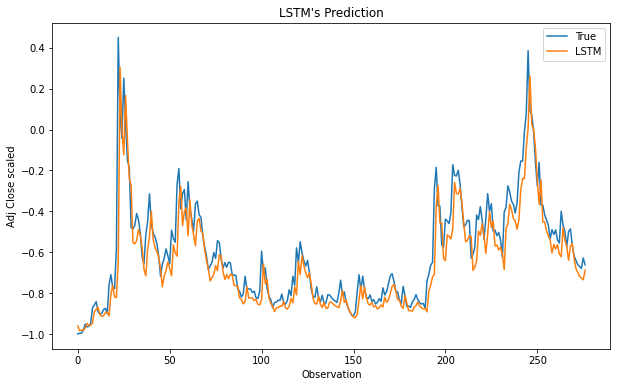

In [170]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close scaled')
plt.legend()
plt.show();